In [2]:
import sys

import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random
import seaborn as sns
import copy

from pylab import rcParams
from scipy.interpolate import interp1d
rcParams['figure.figsize'] = 10, 10

from Models.RealNVP import *
from sklearn import datasets
from Geometry.curves import trainableCurve, BezierCurve
from Geometry.metric import InducedMetricNF

import seaborn as sns

In [3]:
# For reproducibility
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [4]:
device = "cpu"

In [5]:
# Only run once, then load saved model
# flow = train(datasets, max_epochs=10000)

In [6]:
# Load flow
path_model = "TrainedModels/flow.pth"
flow = RealNVP(tfm_layers=6, latent_dim=2, device=device).to(device)
# path_model = "TrainedModels/flow_mix.pth"
# flow = RealNVP(tfm_layers=6, latent_dim=2, device=device, distribution="mixture", num_modes=2).to(device)
flow.load_state_dict(torch.load(path_model))
flow.eval()

RealNVP(
  (block_scale): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=256, out_features=2, bias=True)
    (5): Tanh()
  )
  (block_trans): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=256, out_features=2, bias=True)
  )
  (net_trans): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=2, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=256, out_features=2, bias=True)
    )
    (1): Sequential(
      (0): Linear(in_features=2, out_f

Text(0.5, 1.0, '$X = g(z)$')

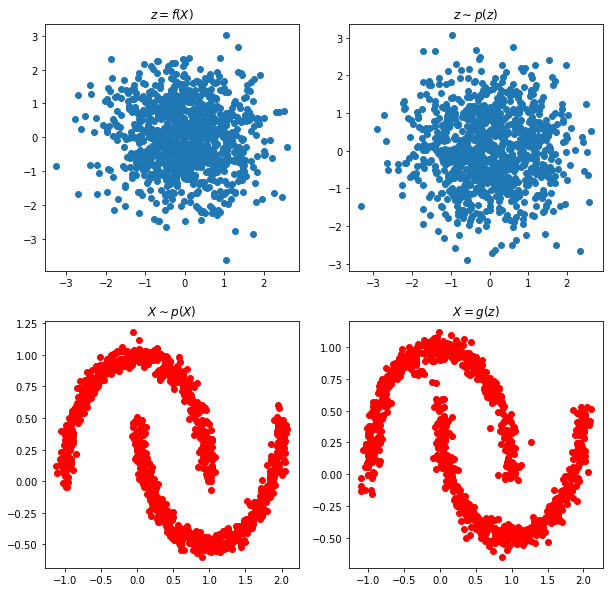

In [7]:
fig = plt.figure()
fig.patch.set_facecolor('w')

noisy_moons = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
z = flow.to_latent(torch.from_numpy(noisy_moons).to(device))[0].cpu().detach().numpy()

plt.subplot(221)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z = f(X)$')

z = np.random.multivariate_normal(np.zeros(2), np.eye(2), 1000)
plt.subplot(222)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z \sim p(z)$')

plt.subplot(223)
x = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
plt.scatter(x[:, 0], x[:, 1], c='r')
plt.title(r'$X \sim p(X)$')

plt.subplot(224)
x = flow.sample(1000).detach().cpu().numpy()
plt.scatter(x[:, 0, 0], x[:, 0, 1], c='r')
plt.title(r'$X = g(z)$')

## Verifying the length

In [31]:
rel_diff = []
metric_space = InducedMetricNF(flow, 2, 2)
for i in tqdm(range(1000)):
    # Discretization of geodesic curve
    N_t = 300
    latent_dim = 2

    bc0 = 0.5 * torch.randn((2,))
    bc1 = 0.5 * torch.randn((2,))

    max_node_count = 10
    t_val = torch.linspace(0, 1, N_t)

    gamma = trainableCurve(bc0, bc1, max_nodes=max_node_count)
    gamma.to(device)

    calc_nf = flow.energy_in_image_space(gamma, t_val, length=True)

    with torch.set_grad_enabled(False):
        res, diff = gamma(t_val.to(device))
        g = res.detach().cpu().numpy()
        dg = diff.detach().cpu().numpy()

    dt = t_val[1] - t_val[0]
    calc_metric = metric_space.curveLength(dt, g, dg, M_batch_size=t_val.shape[0])

    rel_diff.append((calc_metric - calc_nf)/calc_nf)

100%|██████████| 1000/1000 [03:23<00:00,  4.92it/s]


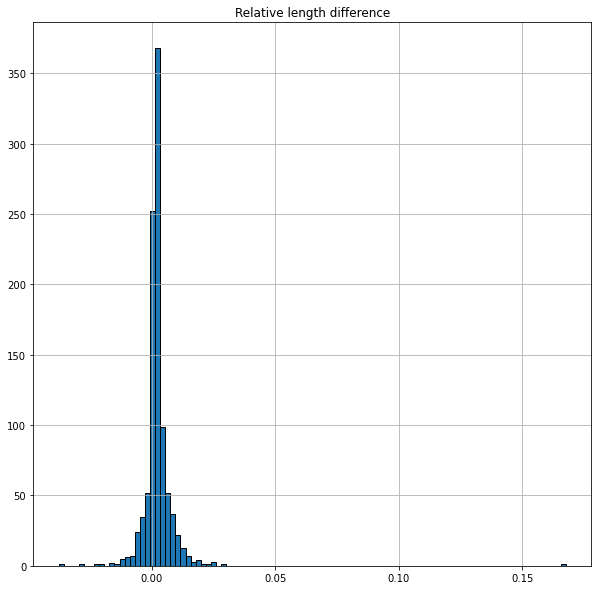

In [32]:
fig = plt.figure()
fig.patch.set_facecolor('w')
plt.grid()
plt.hist(np.array(rel_diff), bins=100, edgecolor='black')
plt.title("Relative length difference")
plt.savefig("Outputs/len_diff.png")

In [36]:
metric_space = InducedMetricNF(flow, 2, 2)

In [37]:
with torch.set_grad_enabled(False):
    res, diff = gamma(t_val.to(device))
    g = res.detach().cpu().numpy()
    dg = diff.detach().cpu().numpy()

In [38]:
dt = t_val[1] - t_val[0]
best_length = metric_space.curveLength(dt, g, dg, M_batch_size=t_val.shape[0])

In [39]:
best_length

tensor(1.8159)

## Verifying length by making the discretization finer

In [28]:
arr_abs_error = []
metric_space = InducedMetricNF(flow, 2, 2)
bc0 = torch.Tensor([-2, -2])
bc1 = torch.Tensor([2, 2])

gamma = trainableCurve(bc0, bc1, max_nodes=max_node_count)
gamma.to(device)

for i in tqdm(range(2, 500)):
    latent_dim = 2

    max_node_count = 10
    t_val = torch.linspace(0, 1, i)



    bc0 = torch.Tensor([-2, -2])
    bc1 = torch.Tensor([2, 2])

    calc_nf = flow.energy_in_image_space(gamma, t_val, length=True)

    with torch.set_grad_enabled(False):
        res, diff = gamma(t_val.to(device))
        g = res.detach().cpu().numpy()
        dg = diff.detach().cpu().numpy()

    dt = t_val[1] - t_val[0]
    calc_metric = metric_space.curveLength(dt, g, dg, M_batch_size=t_val.shape[0])

    arr_abs_error.append(np.abs((calc_metric - calc_nf) / calc_nf))

100%|██████████| 498/498 [01:03<00:00,  7.84it/s]


In [29]:
arr_abs_error = np.array(arr_abs_error)

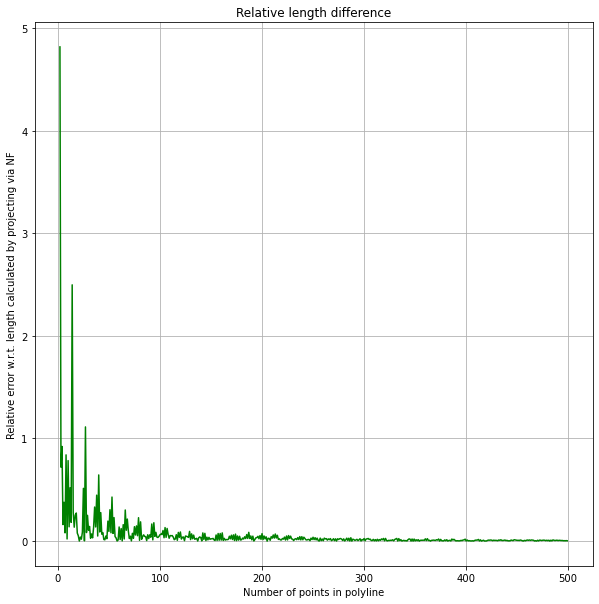

In [36]:
fig = plt.figure()
fig.patch.set_facecolor('w')
plt.grid()
sns.lineplot(x=np.arange(2, 500), y=arr_abs_error, color="g")
plt.title("Relative length difference")
plt.xlabel("Number of points in polyline")
plt.ylabel("Relative error w.r.t. length calculated by projecting via NF")
plt.savefig("Outputs/len_err_diff.png")

## Scratch

In [16]:
metric_space = InducedMetricNF(flow, 2, 2)
N_t = 30000
latent_dim = 2

max_node_count = 10
t_val = torch.linspace(0, 1, N_t)

gamma = trainableCurve(bc0, bc1, max_nodes=max_node_count)
gamma.to(device)

bc0 = torch.Tensor([-2, -2])
bc1 = torch.Tensor([2, 2])

calc_nf = flow.energy_in_image_space(gamma, t_val, length=True)

with torch.set_grad_enabled(False):
    res, diff = gamma(t_val.to(device))
    g = res.detach().cpu().numpy()
    dg = diff.detach().cpu().numpy()

dt = t_val[1] - t_val[0]
calc_metric = metric_space.curveLength(dt, g, dg, M_batch_size=t_val.shape[0])

In [17]:
np.abs(calc_metric - calc_nf)

tensor(0.0002)

In [ ]:
for